#basic heading on what this notebook aims to do, load dta , seciotn and insert into mongodb etc

In [1]:
#Load data and freeze random state for reproducibility

import pandas as pd

df = pd.read_csv("./data.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,200223,Female,21,1,3.0,1,< 1 Year,No,20408.0,160.0,72,0
1,49767,Male,55,1,15.0,0,1-2 Year,Yes,37498.0,26.0,102,0
2,172202,Female,41,1,3.0,0,1-2 Year,Yes,2630.0,26.0,90,0
3,160714,Female,26,1,11.0,0,< 1 Year,No,2630.0,151.0,268,0
4,53273,Male,51,1,40.0,0,1-2 Year,Yes,34006.0,124.0,265,0


In [2]:
n = len(df)

train_end = int(n * 0.6)
batch1_end = train_end + int(n * 0.2)



train_df = df.iloc[:train_end].copy()
batch_1  = df.iloc[train_end:batch1_end].copy()
batch_2  = df.iloc[batch1_end:].copy()



print(f"Train size : {len(train_df)}")
print(f"Batch 1    : {len(batch_1)}")
print(f"Batch 2    : {len(batch_2)}")
print(f"Total      : {len(train_df) + len(batch_1) + len(batch_2)}")



Train size : 228665
Batch 1    : 76221
Batch 2    : 76223
Total      : 381109


In [3]:
# MongoDB connection 
import sys
import os

# Add root directory to path to allow imports
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.db_utils import MongoDBClient
from constant import COLLECTION_NAME

# Initialize MongoDB Client using environmental variables
mongo_client = MongoDBClient()
collection = mongo_client.database[COLLECTION_NAME]

def push_dataframe(df, tag):
    """
    Push a dataframe to MongoDB with a batch tag.
    """
    records = df.copy()
    records["batch_tag"] = tag  # helps tracking source batch
    collection.insert_many(records.to_dict("records"))
    print(f"Inserted {len(records)} records with tag='{tag}'")

print("MongoDB connection established.")

MongoDB connection established.


In [4]:
# ======================================
# DRIFT INJECTION (ONLY FOR BATCH 2)
# ======================================

batch_2_drifted = batch_2.copy()

# --- Feature drift: Age (mean + IQR shift)
batch_2_drifted["Age"] = (
    batch_2_drifted["Age"] * 1.25
).clip(18, 85)

# --- Feature drift: Annual Premium (inflation)
batch_2_drifted["Annual_Premium"] *= 1.4

# --- Feature drift: Vintage (longer customer tenure)
batch_2_drifted["Vintage"] = (
    batch_2_drifted["Vintage"] * 1.3
)

# --- Label drift: increase claim rate
flip_idx = (
    batch_2_drifted[batch_2_drifted["Response"] == 0]
    .sample(frac=0.25, random_state=42)
    .index
)

batch_2_drifted.loc[flip_idx, "Response"] = 1

print("Drift injected into batch_2_drifted")

Drift injected into batch_2_drifted


In [5]:
# ================================
# Insert TRAINING (historical) data
# ================================

push_dataframe(train_df, tag="train")


Inserted 228665 records with tag='train'


In [ ]:
# ================================
# Insert BATCH 1 (clean new data)
# ================================

push_dataframe(batch_1, tag="batch_1_clean")


In [ ]:
# ================================
# Insert BATCH 2 (drifted data)
# ================================

push_dataframe(batch_2_drifted, tag="batch_2_drifted")

In [18]:
# ================================
# Clear MongoDB collection (RESET)
# ================================

deleted = collection.delete_many({})
print(f"Deleted {deleted.deleted_count} documents from '{COLLECTION_NAME}'")


Deleted 304888 documents from 'vehicle-insurance-data'


/tmp/ipykernel_361369/3005376588.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


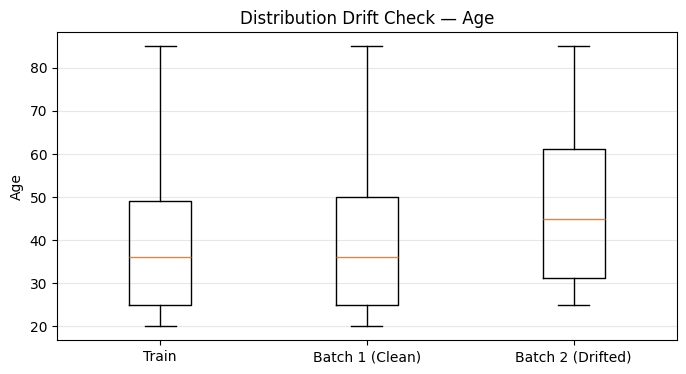

/tmp/ipykernel_361369/3005376588.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


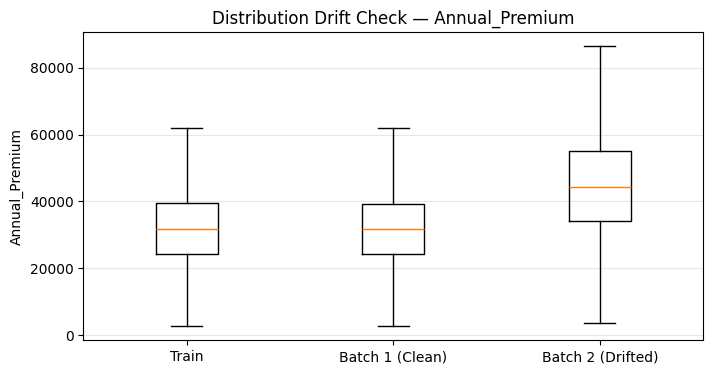

/tmp/ipykernel_361369/3005376588.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


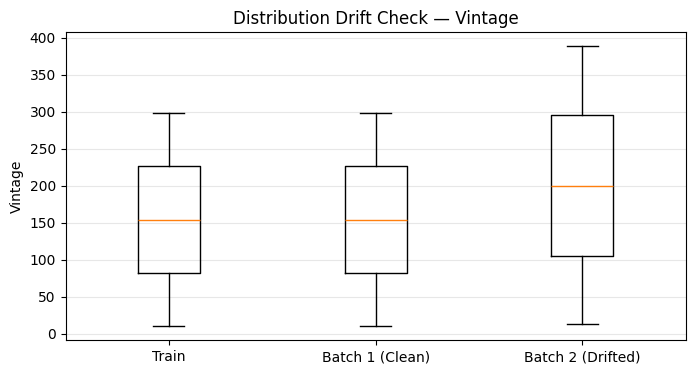

In [21]:
import matplotlib.pyplot as plt

NUMERIC_FEATURES = ["Age", "Annual_Premium", "Vintage"]

def plot_drift(train_df, batch_1, batch_2, feature):
    plt.figure(figsize=(8, 4))

    data = [
        train_df[feature],
        batch_1[feature],
        batch_2[feature]
    ]

    plt.boxplot(
        data,
        labels=["Train", "Batch 1 (Clean)", "Batch 2 (Drifted)"],
        showfliers=False
    )

    plt.title(f"Distribution Drift Check — {feature}")
    plt.ylabel(feature)
    plt.grid(axis="y", alpha=0.3)
    plt.show()


for feature in NUMERIC_FEATURES:
    plot_drift(train_df, batch_1, batch_2_drifted, feature)
